# Image Segmentation for non-agricultural land covers based on U-Net

## Initliasations

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
# Numpy for numerical processing and arrays
import numpy as np

# Useful python libaries for manipulating data
import pickle
import itertools
import glob
import re
import math

In [3]:
# Geospatial libraries to handle georeferenced raster and vector data
import fiona
from fiona import collection
import rasterio
import geopandas as gpd
from shapely.geometry import LineString, mapping, shape
from rasterio.mask import mask
from rasterio.plot import show
from rasterio.transform import Affine
from rasterio.warp import reproject, Resampling
from rasterio import windows

In [4]:
# Matplotlib for data plotting
from matplotlib import pyplot as plt

In [5]:
# Scikit learn and scikit image libraries for machine learning and computer vision tools.
from skimage import io, exposure, measure
from sklearn.metrics import jaccard_similarity_score, classification_report, confusion_matrix
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

In [6]:
# import tensorflow as tf

# Keras deep learning library
import keras
from keras.models import load_model, Model
from keras import backend as K
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Input, concatenate, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Conv2DTranspose, UpSampling2D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras import losses

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [7]:
# Initializse a random number generator to ensure results are reproducible
np.random.seed(7)
# turn warnig off
np.warnings.filterwarnings('ignore')
# print floating points as using fixed point notation i.e. not scientific
np.set_printoptions(suppress=True)
% matplotlib inline

In [9]:
# delcare whether its only RGB-IR Indices or RGB-IR-SLOPE
appendDSM=True
folderRunSuffix = 'RGBIR_NDSM'
numChannels = 7
appendIR=False
if appendDSM and appendIR:
    numChannels = 7
    folderRunSuffix = 'RGBIR_NDSM'
elif not appendDSM and appendIR:
    numChannels = 6
    folderRunSuffix = 'RGBIR'
elif not appendIR and appendDSM:
    numChannels = 4
    folderRunSuffix = 'RGB_nDSM'

In [10]:
# cells to run after file export
# set some useful paths
# RAW INPUTS
root = '/Volumes/NewVolume/DSA/Classify_LandCover/'
ap_rgb_train_dir = os.path.join(root, 'DATA/AP_RGB_TRAIN')  # full res input RGB AP for training
ap_cir_train_dir = os.path.join(root, 'DATA/AP_CIR_TRAIN')  # full res input CIR for training
ap_rgb_test_dir = os.path.join(root, 'DATA/AP_RGB_TEST')  # full res input RGB AP for testing
ap_cir_test_dir = os.path.join(root, 'DATA/AP_CIR_TEST')  # full res input CIR for testing

labels_dir = os.path.join(root, 'DATA/LABELS')  # land cover polygons after generalisation

dsm_dir = os.path.join(root, 'DATA/N_DSM')  # DSM 

# DERIVED INPUTS
image_chips_dir = os.path.join(root, 'DATA/IMAGE_CHIPS',folderRunSuffix)  # pre-procssed image tiles and mask root folder
if (not os.path.exists(image_chips_dir)):
    os.mkdir(image_chips_dir)
model_dir = os.path.join(root, 'MODELS',folderRunSuffix)  # contains the machine learning models
if (not os.path.exists(model_dir)):
    os.mkdir(model_dir)
predictions_dir = os.path.join(root, 'PREDICTIONS','UNET',folderRunSuffix)
if (not os.path.exists(predictions_dir)):
    os.mkdir(predictions_dir)


In [11]:
# function by cate to create 3D tiles 
def get_tile_images(arr, newshape):
    oldshape = np.array(arr.shape)
    repeats = (oldshape / newshape).astype(int)
    tmpshape = np.column_stack([repeats, newshape]).ravel()
    order = np.arange(len(tmpshape))
    order = np.concatenate([order[::2], order[1::2]])
    #pdb.set_trace()
    # newshape must divide oldshape evenly or else ValueError will be raised
    return arr.reshape(tmpshape).transpose(order).reshape(-1, *newshape)

In [11]:
# extract the first 3 bands from 4-band RGBA
# extract the first band (NIR) from 3-band CIR
# resample the NIR band to 25cm
# append the NIR band  onto the RGB image
# append the slope image

def appendMoreBands(RGB_ImageName, CIR_ImageName,nDSM_ImageName, tileYSize, tileXSize):

    with rasterio.open(RGB_ImageName) as rgb_src:
        newHeight = int(rgb_src.height / tileYSize) * tileYSize
        newWidth = int(rgb_src.height / tileXSize) * tileXSize
        # only read image upto size  to which tiling can be done into 256x256 blocks
        # numpy.ndarray - read the first three bands as the last band is alpha
        rgb_image = rgb_src.read([1, 2, 3], window=((0, newWidth), (0, newHeight)))
        # show(rgb_image)
        out_metadata = rgb_src.meta.copy()
        out_transform = rgb_src.transform
            
    if (not CIR_ImageName is None):
        with rasterio.open(CIR_ImageName) as nir_src:
            nir_image = nir_src.read([1], window=(
            (0, newWidth / 2), (0, newHeight / 2)))  # only read in the first band as its the NIR band
            # show(nir_image)
            # upsample the CIR band to match the RGB band
            new_nir_image = np.empty(shape=(nir_image.shape[0],  # same number of bands
                                        round(nir_image.shape[1] * 2),  # 200% resolution
                                        round(nir_image.shape[2] * 2)))
            # upsample the NIR image to 25cm i.e. adjust the new affine transform to the 50% smaller cell size
            aff = nir_src.transform
            newaff = Affine(aff.a / 2, aff.b, aff.c, aff.d, aff.e / 2, aff.f)
        
            reproject(
                nir_image, new_nir_image,
                src_transform=aff,
                dst_transform=newaff,
                src_crs=nir_src.crs,
                dst_crs=nir_src.crs,
                resampling=Resampling.nearest)
            # print(new_nir_image.shape)
            # show(new_nir_image)   

            rgbir = np.append(rgb_image,new_nir_image,axis=0)    
        rgbir_with_indices = add_veg_indices(rgbir)
    
    
    #add slope if asked for
    if (not nDSM_ImageName is None):
        with rasterio.open(nDSM_ImageName) as nDSM_src:
            newHeight = int(nDSM_src.height / tileYSize) * tileYSize
            newWidth = int(nDSM_src.height / tileXSize) * tileXSize
            # only read image upto size  to which tiling can be done into 256x256 blocks
            # numpy.ndarray - read the first three bands as the last band is alpha
            nDSM_image = nDSM_src.read([1],window=((0, newWidth), (0, newHeight)))
            if appendIR:
                rgbir_with_indices = np.append(rgbir_with_indices,nDSM_image,axis=0)
            else:
                rgbir_with_indices = np.append(rgb_image,nDSM_image,axis=0)
            
    rgbir_with_indices_normalised = keras.utils.normalize(rgbir_with_indices,axis=2)
    return rgbir_with_indices_normalised, out_metadata, out_transform

In [12]:
def prepImages(ap_rgb_train_dir,ap_cir_train_dir,image_chips_dir,allPolygons,appendDSM):
    # read the rgb and cir images that we have and store them in a dictionary
    rgb_list = {}
    for filename in os.listdir(ap_rgb_train_dir):
        if filename.endswith(".tif"):
            # get os1k tile name
            os1k_tile = filename[:6]
            if os1k_tile in rgb_list:
                print(os1k_tile + 'already exists so summin wrong?!')
                continue
            else:
                rgb_list[os1k_tile]= os.path.join(ap_rgb_train_dir, filename)
        else:
            continue

    cir_list = {}
    for filename in os.listdir(ap_cir_train_dir):
        if filename.endswith(".tif"):
            # get os1k tile name
            os1k_tile = filename[:6]
            if os1k_tile in cir_list:
                print(os1k_tile + 'already exists so summin wrong?!')
                continue
            else:
                cir_list[os1k_tile]= os.path.join(ap_cir_train_dir, filename)
        else:
            continue

    # make sure that the rgb and nir image list size are identical
    if len(rgb_list) != len(cir_list):
        raise ValueError('RGB and CIR image lists are not identical')
    
    if len(rgb_list) < 1 or len(cir_list) < 1:
        raise ValueError('RGB and CIR image lists are empty')
    
    # iterate through the RGB and CIR images 
    # use only the first band (i.e. NIR) from CIR
    # resample NIR to 25 cms
    # append NIR to RGB
    # create image chips
    for os1k_tile in rgb_list:
        rgb_image = rgb_list[os1k_tile]
        if os1k_tile not in cir_list:
            raise ValueError(os1k_tile + ' not found in cir list - no bueno')
        else:
            cir_image = cir_list[os1k_tile]
        
        ndsm_image = os.path.join(dsm_dir,os1k_tile+'_ndsm.tif')
        if (appendDSM):                    
            if not os.path.exists(ndsm_image):
                raise ValueError('No slope image: '+ndsm_image)

        if appendDSM and appendIR:
             rgbir_image, inputMetadata, inputTransform = appendMoreBands(rgb_image,cir_image,ndsm_image,256,256)
        elif appendIR and not appendDSM:
            rgbir_image, inputMetadata, inputTransform = appendMoreBands(rgb_image,cir_image,None,256,256)
        elif not appendIR and appendDSM:
            print ("calling ndsm")
            rgbir_image, inputMetadata, inputTransform = appendMoreBands(rgb_image,None,ndsm_image,256,256)
        else:
            raise ValueError("dunno what happened")
        
        # Affine(0.25,0.0,462000.0,0.0,-0.25,372000.0)
        ULX = inputTransform.c
        ULY = inputTransform.f
        cellSizeX = inputTransform.a
        cellSizeY = inputTransform.e
        
        # 2 more bands have been added
        rgbir_image_tiled = get_tile_images(rgbir_image,(numChannels,256,256))
     
        # write image chips
        numtiles,numbands,rows,cols = rgbir_image_tiled.shape
        rowOffset = 0
        blockSize = int(math.sqrt(numtiles))
        for tileIndexAlongY in range(0,blockSize):
            tileULY = ULY + (tileIndexAlongY * cellSizeY * 256)
            for tileIndexAlongX in range(0,blockSize):
                tileULX = ULX + (tileIndexAlongX * cellSizeX * 256)
                # print(str(tileULX)+","+str(tileULY))
                globalTileIndex = tileIndexAlongY + tileIndexAlongX + rowOffset
                aTileImage = rgbir_image_tiled[globalTileIndex,:,:,:]
                # aTileImage = np.expand_dims(aTileImage,0)
                tileMetadata = inputMetadata.copy()
                tileTransform = Affine(cellSizeX,
                                   inputTransform.b,
                                   tileULX,
                                   inputTransform.d,
                                   cellSizeY,
                                   tileULY)
                
                # two more bands have been added                
                tileMetadata.update({'driver': 'GTiff',
                                 'dtype': 'float64',
                                 'count': numChannels,
                                 'height': 256,
                                 'width': 256,
                                 'transform': tileTransform,
                                 'nodata':0})
                
                tileFileName = os.path.basename(rgb_image).replace(".tif","_"+str(globalTileIndex).zfill(4)+".tif")
                tileFullName = os.path.join(image_chips_dir, tileFileName)
                with rasterio.open(tileFullName, 'w', **tileMetadata) as dest:
                    dest.write(aTileImage)
                
                #now mask nodata areas in the image
                maskDone = maskImage(tileFullName,allPolygons)
                if (not maskDone):
                    print("failed")
                    
            rowOffset = rowOffset + (blockSize-1)

In [13]:
def add_veg_indices(image):
    red = image[0,:,:]
    green = image[1,:,:]
    blue = image[2,:,:]
    nir = image[3,:,:]   
    
    red_diff = np.subtract(nir,red)
    red_sum = np.add(nir,red)
    ndvi = np.divide(red_diff,red_sum,out=np.zeros_like(red_diff), where=red_sum!=0)
    
    red_green_diff = np.subtract(green,nir)
    red_green_sum = np.add(green,nir)

    ndwi = np.divide(red_green_diff,red_green_sum,out=np.zeros_like(red_green_diff), where=red_green_sum!=0)
    
    new_image = np.stack((image[0,:,:],image[1,:,:],image[2,:,:],image[3,:,:],ndvi,ndwi),axis=0)
    return new_image

In [14]:
def maskImages(train_images_dir,labels_chips_dir, LU_LABELS):
    for filename in os.listdir(train_images_dir):
        if filename.endswith(".tif"):
            training_image_path = os.path.join(train_images_dir,filename)
            #create a list of output ndarrays
            mask_array = []
            #iterate through the mask vectors
            with rasterio.open(training_image_path) as src:
                for LU_LABEL in LU_LABELS:
                    masks = LU_LABELS[LU_LABEL]
                    mask_image, mask_transform = rasterio.mask.mask(src,masks,nodata=0)
                    mask_meta = src.meta.copy()
                    mask_image[mask_image != 0] = LU_LABEL
                    # only use the masked cells from blue band as its identical to others
                    mask_array.append(mask_image[0]) 
            
                #merge the masks into a single image
                #by an element-wise maximum operator
                #assumes that we dont have overlapping masks
                final_mask = mask_array[0].copy()
                for p in range(1,len(mask_array)):
                    final_mask = np.maximum(final_mask,mask_array[p]).copy()

                final_mask = final_mask.astype('uint8')
                final_mask[final_mask < 1] = 0
                
                # skip this tile if it only has nodata otherwise
                # we are overfeeding nodata
                uniqueLabels = np.unique(final_mask)
                if len(uniqueLabels) < 2 and uniqueLabels[0] ==0:
                    continue
                    
                final_mask = np.expand_dims(final_mask, 0)
            
                #save the final mask image
                mask_meta.update({'driver': 'GTiff',
                             'dtype': 'uint8',
                             'count': 1,
                             'height': final_mask.shape[1],
                             'width': final_mask.shape[2],
                             'transform': mask_transform,
                             'nodata':0})
                label_file_name = os.path.join(labels_chips_dir,filename.replace(".tif","_labels.tif"))
                with rasterio.open(label_file_name, 'w', **mask_meta) as dest:
                    dest.write(final_mask)

In [15]:
def maskImage(input_image_name,allPolygons):
    try:
        temp_file_name = input_image_name.replace(".tif","_temp.tif")
        maskDone = False
        with rasterio.open(input_image_name) as src:
            mask_image, mask_transform = rasterio.mask.mask(src,allPolygons,nodata=0)
            mask_meta = src.meta.copy()            
            # skip this tile if it only has nodata otherwise
            # we are overfeeding nodata
            uniqueLabels = np.unique(mask_image[0,:,:])
            if len(uniqueLabels) < 2 and uniqueLabels[0] ==0:                
                maskDone= input_image_name
            else:
                with rasterio.open(temp_file_name, 'w', **mask_meta) as dest:
                    dest.write(mask_image)
                    maskDone = temp_file_name
        
        if (maskDone == input_image_name):
            os.remove(input_image_name)
        elif (maskDone == temp_file_name):
            os.remove(input_image_name)
            os.rename(temp_file_name,input_image_name)
        return True    
    except Exception as e:
        print(e)
        return maskDone
            

In [16]:
# Create training data polygons from landcover shapefile
# open the landcover polygons and create an array of geometries for unique LU_LABELS
def makeMasks(shapeFileName,labelFieldName):
    LU_LABELS = {}
    with fiona.open(shapeFileName, 'r') as landcovers:
        for feature in landcovers:
            LU_LABEL = feature['properties'][labelFieldName]
            landcover = feature["geometry"]
            if LU_LABEL in LU_LABELS:
                oldArray = LU_LABELS[LU_LABEL]
                oldArray.append(landcover)
            else:
                LU_LABELS[LU_LABEL] = [landcover]
    return LU_LABELS

In [12]:
# to show the confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
 
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
 
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [13]:
# to calculate all metrics
def accuracy_statistics(true_class, predicted_class):
   
    # classification report
    #target_names = ["Class {}".format(i) for i in range(3)]
    print('Classification Report')
    print(classification_report(true_class, predicted_class))
   
    # jaccard
    print('Jaccard Score:')
    print(jaccard_similarity_score(true_class, predicted_class))
   
    # confusion matrix
    # plt.figure()
    print ('Confusion Matrix')
    #print(confusion_matrix(true_class, predicted_class))
    cnf_matrix = confusion_matrix(true_class, predicted_class)

    plot_confusion_matrix(cnf_matrix, classes=['NoData', 'Solar Panel', 'Trees','Built Structure','Pond'],
                          title='Confusion matrix, without normalization')
    plot_confusion_matrix(cnf_matrix, classes=['NoData', 'Solar Panel', 'Trees','Built Structure','Pond'], normalize=True,
                          title='Normalized confusion matrix')

In [19]:
# read land cover polygon  into geometry arrays that rasterio will use to create masks
labels_shp = os.path.join(labels_dir, 'Labels4Classes.shp')
LU_LABELS = makeMasks(labels_shp,'LU_LABEL')

In [20]:
# create a global list of vectors for creating nodata area in RGB Images
allPolygons = []
for LU_LABEL in LU_LABELS:
    allPolygons.extend(LU_LABELS[LU_LABEL])

In [21]:
# preprocess the training RGB and CIR images to resample CIR, extract NIR band, 
# append NIR band to RGB, split into small tiles
# create no data areas
train_chips_dir = os.path.join(image_chips_dir, 'TRAIN')
if (not os.path.exists(train_chips_dir)):
    os.mkdir(train_chips_dir)
prepImages(ap_rgb_train_dir,ap_cir_train_dir,train_chips_dir,allPolygons,appendDSM)

calling ndsm
calling ndsm
calling ndsm
calling ndsm
calling ndsm
calling ndsm
calling ndsm
calling ndsm
calling ndsm


In [15]:
# cells to run after file export
# using rasterio mask function to mask pixels using LU_LABEL in the training images
train_images_dir = os.path.join(image_chips_dir,'TRAIN')

train_labels_chips_dir = os.path.join(train_images_dir,'LABELS')
if (not os.path.exists(train_labels_chips_dir)):
    os.mkdir(train_labels_chips_dir)

In [23]:
maskImages(train_images_dir,train_labels_chips_dir,LU_LABELS)

In [24]:
# preprocess the test RGB and CIR images to resample CIR, extract NIR band, append NIR band to RGB, split into small tiles
test_chips_dir = os.path.join(image_chips_dir, 'TEST')
if (not os.path.exists(test_chips_dir)):
    os.mkdir(test_chips_dir)
prepImages(ap_rgb_test_dir,ap_cir_test_dir,test_chips_dir,allPolygons,appendDSM)

calling ndsm
calling ndsm
calling ndsm
calling ndsm
calling ndsm
calling ndsm
calling ndsm
calling ndsm
calling ndsm
calling ndsm
calling ndsm
calling ndsm
calling ndsm


In [14]:
# cells to run after file export
test_images_dir = os.path.join(image_chips_dir,'TEST')

test_labels_chips_dir = os.path.join(test_images_dir,'LABELS')
if (not os.path.exists(test_labels_chips_dir)):
    os.mkdir(test_labels_chips_dir)

In [26]:
# using rasterio mask function to mask pixels using LU_LABEL in the test images
maskImages(test_images_dir,test_labels_chips_dir,LU_LABELS)

# Convolutional neural network
The last approach will implement Unet - a popular convolutional neural network for image classifcation

### Set up the training data

In [16]:
# set paths to the training data
image_chips = train_images_dir
label_chips = train_labels_chips_dir

In [17]:
# Class to store data and respective labels
# imagese are split into halves..first half used for training, and remaining half into validation
class train_data():
    
    def __init__(self, image, label):
        self.image = []
        self.label = []
        for file in os.listdir(image):
            if file.endswith(".tif"):
                label_file= os.path.join(label,file.replace(".tif","_labels.tif"))
                self.image.append(io.imread(image+"/"+file,0))
                self.label.append(io.imread(label_file,0))
    
    # training half
    def get_image(self):
        return np.array(self.image[:int(len(self.image)/2)])

    def get_label(self):
        return np.array(self.label[:int(len(self.image)/2)])
    
    # validation half
    def get_validation_image(self):
        return np.array(self.image[int(len(self.image)/2):])
    
    def get_validation_label(self):
        return np.array(self.label[int(len(self.image)/2):])
        
    def set_image(self, new_images):
        self.image = new_image
    
    def set_label(self,new_label):
        self.label = new_label

In [18]:
# run the training data creation
train_set = train_data(image_chips, label_chips)

In [19]:
# access the training set
train_images = train_set.get_image()
train_labels = train_set.get_label()
# access the validation set
validation_images = train_set.get_validation_image()
validation_labels = train_set.get_validation_label()
# one hot encode the labels
train_labels_encoded = to_categorical(train_labels, num_classes=5)
validation_labels_encoded = to_categorical(validation_labels, num_classes=5)

In [20]:
# check that Keras expects the bands to be passed last - i.e. the data is shaped (256, 256, 12)
keras.backend.image_data_format()

'channels_last'

In [32]:
smooth = 1.

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [33]:
def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

In [34]:
def unet_zhixuhao(pretrained_weights = None,input_size = (256,256,numChannels)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(5, (1, 1), activation = 'softmax')(conv9)

    model = Model(input = inputs, output = conv10)

    model.compile(optimizer = Adam(lr = 1e-4), loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
    model.summary()

    if(pretrained_weights):
        model.load_weights(pretrained_weights)

    return model

In [21]:
# define the Unet architecture
def unet_cate(pretrained_weights = None,input_size = (256,256,numChannels)):
    inputs = Input(input_size)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
    
    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    # use softmax in order to only output one class per pixel (unlike sigmoid which can have multiclass)
    conv10 = Conv2D(5, (1, 1), activation='softmax')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])
    # see if a different loss and metrics can improve e.g. sorenson-dice
    # model.compile(optimizer=Adam(lr=1e-9), loss='binary_crossentropy', metrics=['accuracy'])
    # model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    model.compile(optimizer=Adam(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    # model.compile(optimizer=Adam(lr=1e-9), loss=dice_coef_loss, metrics=[dice_coef])
    model.summary()

    if(pretrained_weights):
        model.load_weights(pretrained_weights)
    
    return model

In [22]:
# train the model
model = unet_cate()
model.fit(train_images, train_labels_encoded, validation_data=(validation_images, validation_labels_encoded), epochs=50,
          batch_size=8, shuffle=True)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 4)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 32) 1184        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 32) 9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 128, 128, 32) 0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

126/126 [==============================] - 204s 2s/step - loss: 0.3507 - acc: 0.8374 - val_loss: 0.2801 - val_acc: 0.9546
Epoch 9/50
126/126 [==============================] - 204s 2s/step - loss: 0.3060 - acc: 0.9594 - val_loss: 0.2629 - val_acc: 0.9549
Epoch 10/50
126/126 [==============================] - 205s 2s/step - loss: 0.2644 - acc: 0.9616 - val_loss: 0.2159 - val_acc: 0.9493
Epoch 11/50
126/126 [==============================] - 205s 2s/step - loss: 0.1958 - acc: 0.9659 - val_loss: 0.1690 - val_acc: 0.9496
Epoch 12/50
126/126 [==============================] - 204s 2s/step - loss: 0.1523 - acc: 0.9687 - val_loss: 0.1861 - val_acc: 0.9509
Epoch 13/50
126/126 [==============================] - 203s 2s/step - loss: 0.1284 - acc: 0.9702 - val_loss: 0.1569 - val_acc: 0.9527
Epoch 14/50
126/126 [==============================] - 203s 2s/step - loss: 0.1162 - acc: 0.9714 - val_loss: 0.1451 - val_acc: 0.9541
Epoch 15/50
126/126 [==============================] - 203s 2s/step - loss:

In [37]:
# save the model and weights
model_path = os.path.join(model_dir, 'landcovers_Unet_50epoch_'+folderRunSuffix+'.h5')
model.save(model_path)

In [38]:
#model = load_model(model_path)

# increase the learning rate
#lr = 0.00001
#K.set_value(model.optimizer.lr, lr)

#model.fit(train_images, train_labels_encoded, validation_data=(validation_images, validation_labels_encoded), epochs=10,
#          batch_size=8, shuffle=True)
#model_path = os.path.join(model_dir, '20181008_Unet_20epoch.h5')
#model.save(model_path)

In [39]:
#model = load_model(model_path)

# try increasing the learning rate as little improvement was seen in previous epochs
#lr = 0.000001
#K.set_value(model.optimizer.lr, lr)

#model.fit(train_images, train_labels_encoded, validation_data=(validation_images, validation_labels_encoded), epochs=10,
#          batch_size=2, shuffle=True)
#model_path = os.path.join(model_dir, '20181008_Unet_30epoch.h5')
#model.save(model_path)

In [40]:
# read in the latest trained model
unet_model = load_model(model_path)

# non custom load model syntax
#unet_model = load_model(modelPath,custom_objects={'dice_coef_loss': dice_coef_loss,'dice_coef':dice_coef})

In [41]:
# load test data
test_image_chips = test_images_dir 
test_label_chips = test_labels_chips_dir 

class test_data():
    
    def __init__(self, image, label):
        self.image = []
        self.label = []
        self.filename = [] # store the filename because we can use it later to recreate the predicted image for it
        
        for file in os.listdir(image):
            
            if file.endswith(".tif"):
                label_file= os.path.join(label,file.replace(".tif","_labels.tif"))
                self.image.append(io.imread(image+"/"+file,0))
                self.label.append(io.imread(label_file,0))
                self.filename.append(file)
               
    def get_image(self):
        return np.array(self.image[:int(len(self.image))])

    def get_label(self):
        return np.array(self.label[:int(len(self.image))])
        
    def set_image(self, new_images):
        self.image = new_image
    
    def set_label(self,new_label):
        self.label = new_label

In [42]:
# create the test set
test_set = test_data(test_image_chips, test_label_chips)
# access the test images and labels
test_images = test_set.get_image()
test_label = test_set.get_label()
# one-hot-encode the labels
test_label_encoded = to_categorical(test_label, num_classes=5)

In [43]:
# make predictions on the test set using the trained model
test_predict = unet_model.predict(test_images, verbose=1)

238/238 [==============================] - 101s 424ms/step


In [44]:
# decode the predictions
test_predict_decoded = np.argmax(test_predict, axis=3)

Classification Report
             precision    recall  f1-score   support

          0       1.00      0.99      0.99  11478610
          1       0.00      0.00      0.00     40224
          2       0.44      1.00      0.61   1879876
          3       0.00      0.00      0.00    491033
          4       0.00      0.00      0.00   1707825

avg / total       0.79      0.85      0.80  15597568

Jaccard Score:
0.8459857331604517
Confusion Matrix
Confusion matrix, without normalization


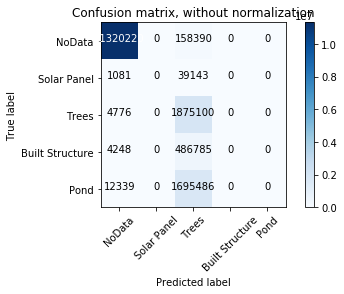

Normalized confusion matrix


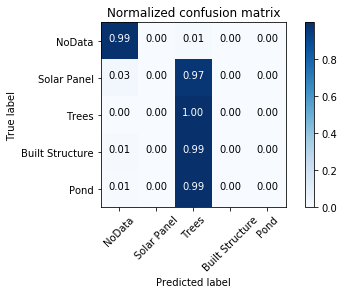

In [45]:
# generate accuracy statistics
accuracy_statistics(test_label.ravel(), test_predict_decoded.ravel())

### Post-processing
In order to generate coastline from the predicted regions, some post-processing is necessary to re-establish the order of the image tiles.

In [46]:
# iterate through the test_images, find the related predicted arrays, find the geotransformation of the test_image it came from
# and the save the predicted array as an image using the geotransform
for tileNum in range(len(test_predict_decoded)):
    imgFileName = test_set.filename[tileNum]
    imageFullName = os.path.join(test_image_chips,imgFileName)
    with rasterio.open(imageFullName) as src:
        out_transform = src.transform
        out_meta = {'driver': 'GTiff',
                    'dtype': 'uint8',
                    'count': 1,
                    'height': 256,
                    'width': 256,
                    'crs': src.crs,
                    'transform': out_transform,
                    'nodata':0}
        predictionFileName = os.path.join(predictions_dir, imgFileName.replace(".tif","_prediction.tif"))
        with rasterio.open(predictionFileName, 'w', **out_meta) as dest:
                    im_prediction = test_predict_decoded[tileNum,:,:]
                    im_prediction = np.expand_dims(im_prediction, 0)
                    im_prediction = im_prediction.astype('uint8')
                    dest.write(im_prediction) 